In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
tf.test.gpu_device_name()

''

In [2]:
# Load accelData from pickle

import pickle
import numpy as np
import matplotlib.pyplot as plt

# open accelData pickle
import pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

# Remove time column from accelData Measurements
accelData['Measurements with Time'] = accelData['Measurements']

for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

In [3]:
# Create a window generator function to save memory
def window_generator_old(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates
        batch_features = []
        batch_labels = []
        for i in np.random.permutation(len(data)):
            print(f'Processing trial {i} of {len(data)}')
            windows = createWindows(data[i], windowSize, stride)
            for window in windows:
                # Normalize the window
                window_normalized = (window - np.mean(window)) / np.std(window)
                batch_features.append(window_normalized)
                batch_labels.append(labels[i])

                if len(batch_features) == batch_size:
                    print('Yielding batch')
                    print(np.array(batch_features).shape)
                    # Yield the batch data
                    yield np.array(batch_features), np.array(batch_labels)
                    batch_features = []
                    batch_labels = []

def window_generator(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates
        batch_features = []
        batch_labels = []
        batch_windows = []
        for i in np.random.permutation(len(data)):
            batch_windows.append(data[i])
            # Normalize the window
            #window_normalized = (window - np.mean(window, axis=0)) / np.std(window, axis=0)
            #batch_features.append(window_normalized)
            batch_labels.append(labels[i])
        


            if len(batch_windows) == batch_size:
                #batch_windows_array = np.array(batch_windows)
                #batch_features= vectorized_normalization(batch_windows_array)
                # Yield the batch data
                yield np.array(batch_windows), np.array(batch_labels)
                batch_features = []
                batch_labels = []


def vectorized_normalization(windows):
    # Compute means and standard deviations for each window
    means = windows.mean(axis=1, keepdims=True)
    stds = windows.std(axis=1, keepdims=True)

    # Normalize
    normalized_windows = (windows - means) / stds

    return normalized_windows


from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Normalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


# class weight import
from sklearn.utils import class_weight

def build_model(input_shape, num_classes):
    oldmodel = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model = Sequential([
        Normalization(input_shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),  # Reduced filters
        MaxPooling1D(pool_size=2),
        Flatten(),  # Removed one Conv1D and one Dropout layer for simplicity
        Dense(64, activation='relu'),  # Reduced the size of the dense layer
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])


    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=False)
    return model




def createWindows(data, windowSize, stride):
    windows = []
    for i in range(0, len(data) - windowSize, stride):
        windows.append(data[i:i+windowSize])
    return windows
    
def batchWindowClassification(trials, labels, windowSize, stride, batch_size=100, verbose=False):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(trials, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    if verbose:
        # plot histogram showing distribution of labels
        plt.hist(y_train)
        # title
        plt.title('Distribution of labels in training set')
        plt.show()

        plt.hist(y_test)
        # title
        plt.title('Distribution of labels in testing set')
        plt.show()  


        print(y_train)
        print(y_test)

    unique_labels = np.unique(np.concatenate((y_train, y_test)))
    num_classes = len(unique_labels)
    if verbose:
        print(f"Number of unique classes: {num_classes}")

    # Prepare labels for training
    encoder = LabelEncoder()
    encoder.fit(np.concatenate((y_train, y_test)))

    # Split X_train into windows
    trainWindows = []
    trainWindowLabels = []
    for i in range(len(X_train)):
        windows = createWindows(X_train[i], windowSize, stride)
        trainWindows.extend(windows)
        labelArray = np.full(len(windows), y_train[i])
        # Convert labelArray to a list
        trainWindowLabels.extend(labelArray.tolist())

    valWindows = []
    valWindowLabels = []
    for i in range(len(X_val)):
        windows = createWindows(X_val[i], windowSize, stride)
        valWindows.extend(windows)
        labelArray = np.full(len(windows), y_val[i])
        # Convert labelArray to a list
        valWindowLabels.extend(labelArray.tolist())
    
    print(len(trainWindows))

    # encode trainWindowLabels
    encoded_trainWindowLabels = encoder.transform(trainWindowLabels)
    encoded_trainWindowLabels = to_categorical(encoded_trainWindowLabels, num_classes=num_classes)

    # encode valWindowLabels
    encoded_valWindowLabels = encoder.transform(valWindowLabels)
    encoded_valWindowLabels = to_categorical(encoded_valWindowLabels, num_classes=num_classes)


    # Creating generators for training and validation
    train_gen = window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=batch_size)
    val_gen = window_generator(valWindows, encoded_valWindowLabels, windowSize, stride, batch_size=batch_size)

    # Assuming `y_train` contains the original labels
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))


    model = build_model((windowSize, 16), 3)

    # Adapting the Normalization layer with a batch of data from the training set
    for X_batch, _ in window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=128):
        model.layers[0].adapt(X_batch)  # Adapt the normalization layer
        break 

    # Instantiate the callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    # Assume your model is named 'model' and is already defined
    model.fit(train_gen, 
        #callbacks=[reduce_lr], 
        #validation_data=val_gen,
        steps_per_epoch=max(1, len(trainWindows) // batch_size), 
        #steps_per_epoch=100,
        epochs=10, 
        verbose=1) #, class_weight=class_weights_dict)    

    # Split X_train into windows
    testWindows = []
    testWindowLabels = []
    for i in range(len(X_test)):
        windows = createWindows(X_test[i], windowSize, stride)
        testWindows.extend(windows)
        labelArray = np.full(len(windows), y_test[i])
        # Convert labelArray to a list
        testWindowLabels.extend(labelArray.tolist())

    # encode testWindowLabels
    encoded_testWindowLabels = encoder.transform(testWindowLabels)
    encoded_testWindowLabels = to_categorical(encoded_testWindowLabels, num_classes=num_classes)

    # Creating generators for testing
    test_gen = window_generator(testWindows, encoded_testWindowLabels, windowSize, stride, batch_size=batch_size)
    test_steps = max(1, len(testWindows) // batch_size)  # Ensure at least 1 step


    # Evaluate the model
    loss, accuracy = model.evaluate(test_gen, steps= test_steps, verbose=1)

    # Print out predictions
    predictions = model.predict(test_gen, steps=test_steps, verbose=1)

    # transform predictions to labels
    predictions = np.argmax(predictions, axis=1)
    predictions = encoder.inverse_transform(predictions)
    # plot histogram showing distribution of predictions
    plt.hist(predictions)
    # title
    plt.title('Distribution of predictions')
    plt.show()

    # print distribution of predictions
    print(np.unique(predictions, return_counts=True))

    print(f'Accuracy: {accuracy}')
    print(f'Loss: {loss}')

    return loss, accuracy, model



windowSize: 100, stride: 50.0
226197
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

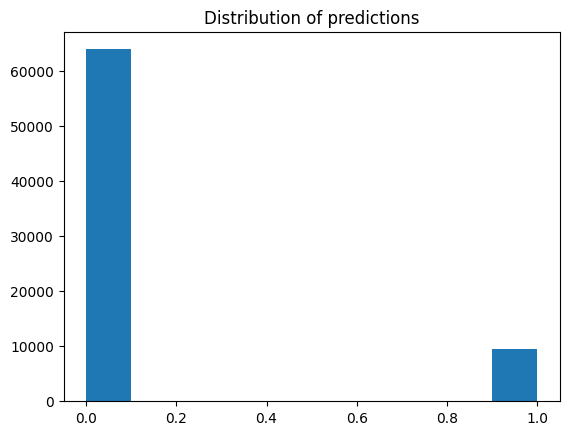

(array([0., 1.]), array([63924,  9576], dtype=int64))
Accuracy: 0.6876734495162964
Loss: 0.9582388401031494
windowSize: 1000, stride: 500.0
22491
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s

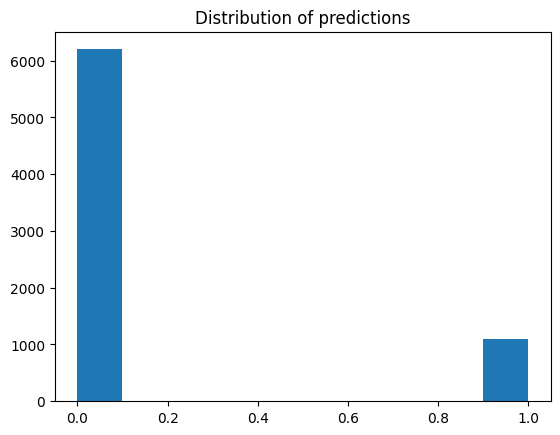

(array([0., 1.]), array([6199, 1101], dtype=int64))
Accuracy: 0.6791780591011047
Loss: 1.0459333658218384
windowSize: 5000, stride: 2500.0
4388
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

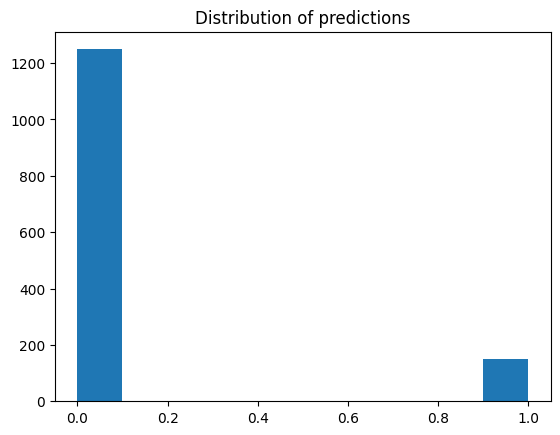

(array([0., 1.]), array([1249,  151], dtype=int64))
Accuracy: 0.6871428489685059
Loss: 0.8094862699508667
windowSize: 10000, stride: 5000.0
2121
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si

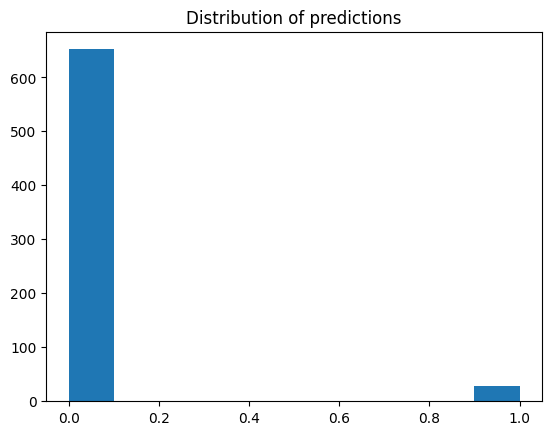

(array([0., 1.]), array([652,  28], dtype=int64))
Accuracy: 0.699999988079071
Loss: 0.7115895748138428


In [10]:
# Test batchWindowClassification with different windowSizes, and strides of windowSizes/2 
# Make batch size inversely proportional to windowSize
# Make verbose=False

windowSizes = [100, 1000, 5000, 10000]
strides = [50, 500, 2500, 5000]
allResults = []
batchSize = [500, 100, 50, 20]

for windowSize in windowSizes:
    # get index of windowSize
    index = windowSizes.index(windowSize)
    
    print(f'windowSize: {windowSize}, stride: {windowSize/2}')
    loss, accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], windowSize, int(windowSize/2), batch_size=batchSize[index], verbose=False)
    
    # save results in variable
    results = {
        'windowSize': windowSize,
        'stride': int(windowSize/2),
        'batchSize': batchSize[index],
        'loss': loss,
        'accuracy': accuracy,
        'model': model
    }
    allResults.append(results)



In [12]:
# pretty print results
for result in allResults:
    print(f'windowSize: {result["windowSize"]}, stride: {result["stride"]}, batchSize: {result["batchSize"]}, loss: {result["loss"]}, accuracy: {result["accuracy"]}')

windowSize: 100, stride: 50, batchSize: 500, loss: 0.9582388401031494, accuracy: 0.6876734495162964
windowSize: 1000, stride: 500, batchSize: 100, loss: 1.0459333658218384, accuracy: 0.6791780591011047
windowSize: 5000, stride: 2500, batchSize: 50, loss: 0.8094862699508667, accuracy: 0.6871428489685059
windowSize: 10000, stride: 5000, batchSize: 20, loss: 0.7115895748138428, accuracy: 0.699999988079071


windowSize: 100, stride: 50.0
452353
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

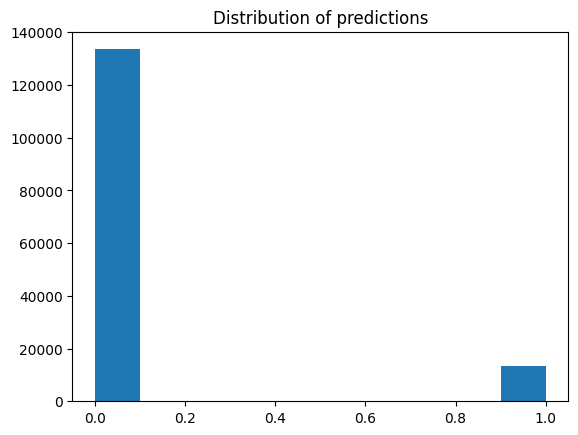

(array([0., 1.]), array([133531,  13469], dtype=int64))
Accuracy: 0.6878027319908142
Loss: 0.8234582543373108
windowSize: 1000, stride: 500.0
44940
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To

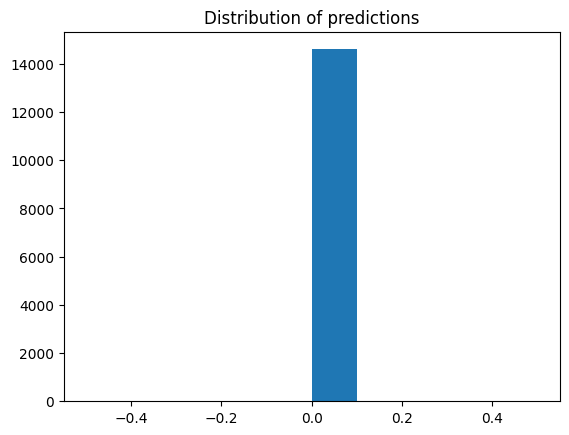

(array([0.]), array([14600], dtype=int64))
Accuracy: 0.7042465806007385
Loss: 0.7595071196556091
windowSize: 5000, stride: 2500.0
8729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this

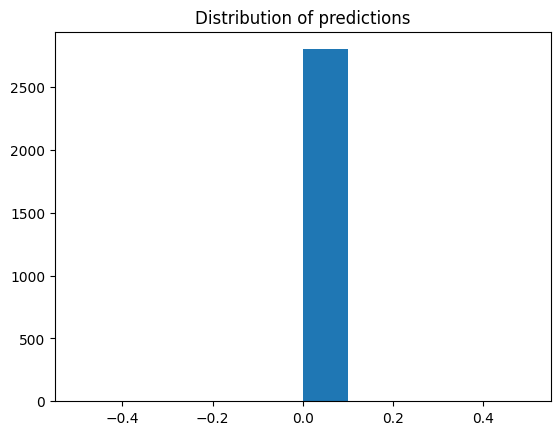

(array([0.]), array([2800], dtype=int64))
Accuracy: 0.7117857336997986
Loss: 1.0490531921386719
windowSize: 10000, stride: 5000.0
4204
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this

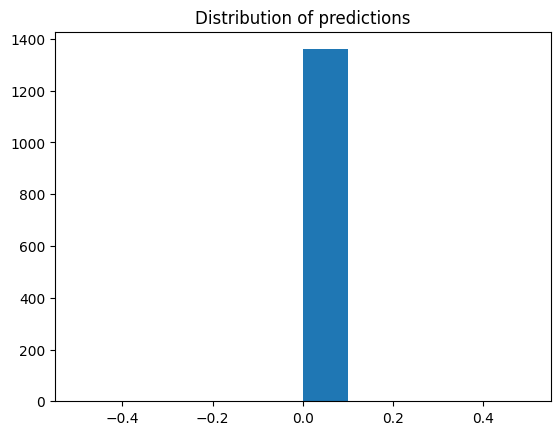

(array([0.]), array([1360], dtype=int64))
Accuracy: 0.6985294222831726
Loss: 0.6988150477409363


In [13]:
# Test batchWindowClassification with different windowSizes, and strides of windowSizes/4
# Make batch size inversely proportional to windowSize
# Make verbose=False

windowSizes = [100, 1000, 5000, 10000]
allResults4 = []
batchSize = [500, 100, 50, 20]

for windowSize in windowSizes:
    # get index of windowSize
    index = windowSizes.index(windowSize)
    
    print(f'windowSize: {windowSize}, stride: {windowSize/2}')
    loss, accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], windowSize, int(windowSize/4), batch_size=batchSize[index], verbose=False)
    
    # save results in variable
    results = {
        'windowSize': windowSize,
        'stride': int(windowSize/2),
        'batchSize': batchSize[index],
        'loss': loss,
        'accuracy': accuracy,
        'model': model
    }
    allResults4.append(results)

In [15]:
# pretty print results
for result in allResults4:
    print(f'windowSize: {result["windowSize"]}, stride: {result["stride"]}, batchSize: {result["batchSize"]}, loss: {result["loss"]}, accuracy: {result["accuracy"]}')

windowSize: 100, stride: 50, batchSize: 500, loss: 0.8234582543373108, accuracy: 0.6878027319908142
windowSize: 1000, stride: 500, batchSize: 100, loss: 0.7595071196556091, accuracy: 0.7042465806007385
windowSize: 5000, stride: 2500, batchSize: 50, loss: 1.0490531921386719, accuracy: 0.7117857336997986
windowSize: 10000, stride: 5000, batchSize: 20, loss: 0.6988150477409363, accuracy: 0.6985294222831726


windowSize: 5000, stride: 1250.0, batchSize: 500
8729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Pl

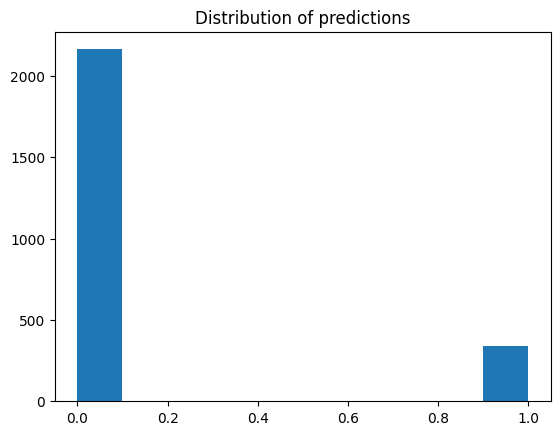

(array([0., 1.]), array([2163,  337], dtype=int64))
Accuracy: 0.701200008392334
Loss: 0.648048460483551
windowSize: 5000, stride: 1250.0, batchSize: 100
8729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'poson

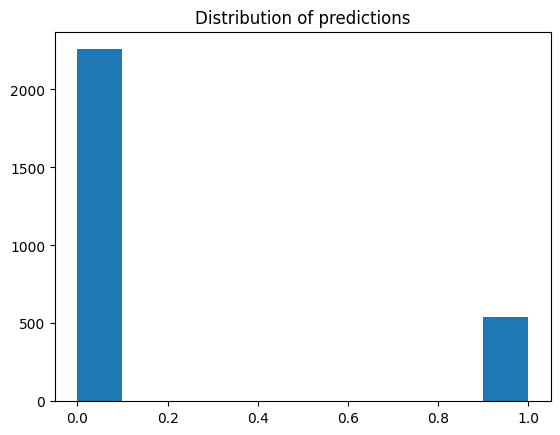

(array([0., 1.]), array([2258,  542], dtype=int64))
Accuracy: 0.6299999952316284
Loss: 1.2271199226379395
windowSize: 5000, stride: 1250.0, batchSize: 50
8729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'poso

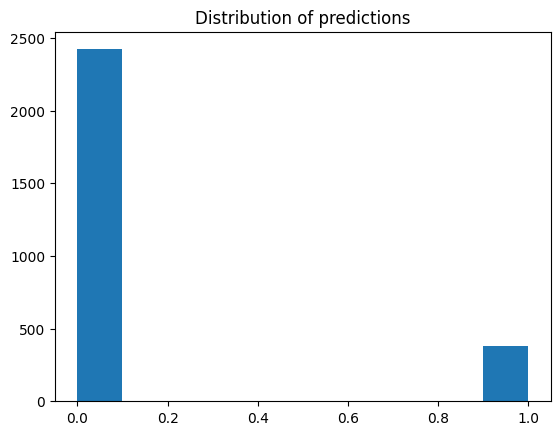

(array([0., 1.]), array([2422,  378], dtype=int64))
Accuracy: 0.7535714507102966
Loss: 0.8309135437011719
windowSize: 5000, stride: 1250.0, batchSize: 20
8729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'poso

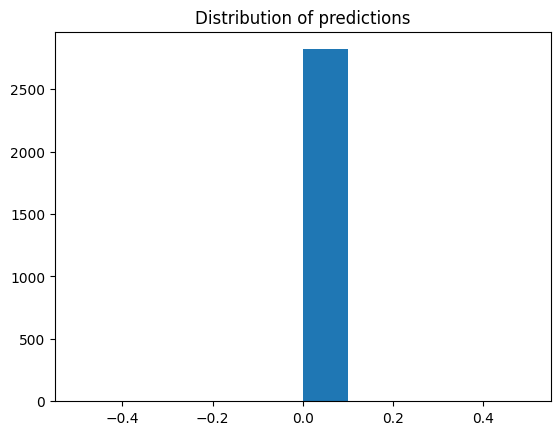

(array([0.]), array([2820], dtype=int64))
Accuracy: 0.6985815763473511
Loss: 0.6165298223495483


In [16]:
# use windowsize=5000, stride=windiwsSize/4 and find best batch size
# Make verbose=False

windowSize = 5000
batchSizes = [500, 100, 50, 20]
allResultsBatch = []

for batchSize in batchSizes:
    print(f'windowSize: {windowSize}, stride: {windowSize/4}, batchSize: {batchSize}')
    loss, accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], windowSize, int(windowSize/4), batch_size=batchSize, verbose=False)
    
    # save results in variable
    results = {
        'windowSize': windowSize,
        'stride': int(windowSize/4),
        'batchSize': batchSize,
        'loss': loss,
        'accuracy': accuracy,
        'model': model
    }
    allResultsBatch.append(results)

In [17]:
# pretty print results
for result in allResultsBatch:
    print(f'windowSize: {result["windowSize"]}, stride: {result["stride"]}, batchSize: {result["batchSize"]}, loss: {result["loss"]}, accuracy: {result["accuracy"]}')

windowSize: 5000, stride: 1250, batchSize: 500, loss: 0.648048460483551, accuracy: 0.701200008392334
windowSize: 5000, stride: 1250, batchSize: 100, loss: 1.2271199226379395, accuracy: 0.6299999952316284
windowSize: 5000, stride: 1250, batchSize: 50, loss: 0.8309135437011719, accuracy: 0.7535714507102966
windowSize: 5000, stride: 1250, batchSize: 20, loss: 0.6165298223495483, accuracy: 0.6985815763473511


windowSize: 5000, stride: 1, batchSize: 50
2214
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please r

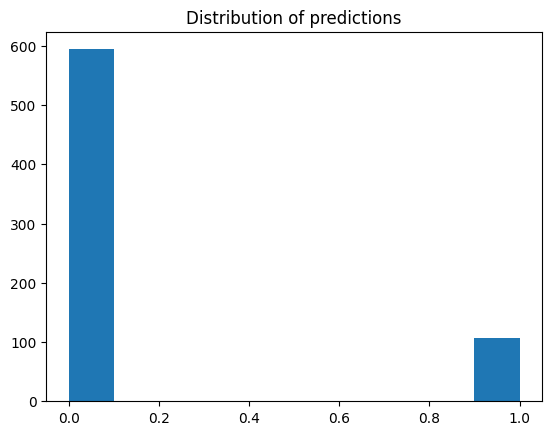

(array([0., 1.]), array([594, 106], dtype=int64))
Accuracy: 0.6528571248054504
Loss: 0.7208598852157593
windowSize: 5000, stride: 0.75, batchSize: 50
2941
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlya

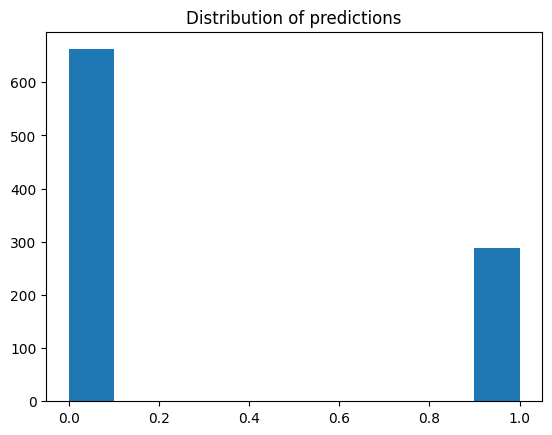

(array([0., 1.]), array([662, 288], dtype=int64))
Accuracy: 0.6410526037216187
Loss: 0.7310370802879333
windowSize: 5000, stride: 0.5, batchSize: 50
4388
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyar

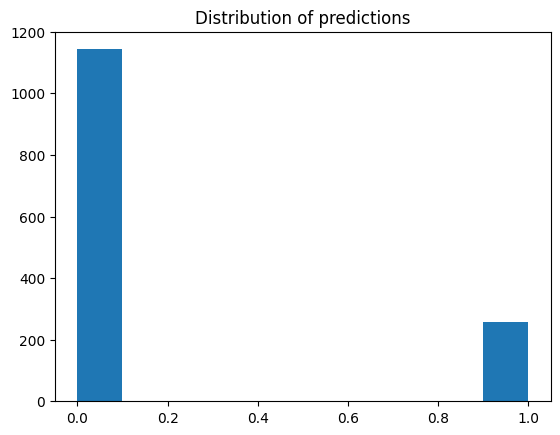

(array([0., 1.]), array([1143,  257], dtype=int64))
Accuracy: 0.6592857241630554
Loss: 0.9154693484306335
windowSize: 5000, stride: 0.3333333333333333, batchSize: 50
6560
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no att

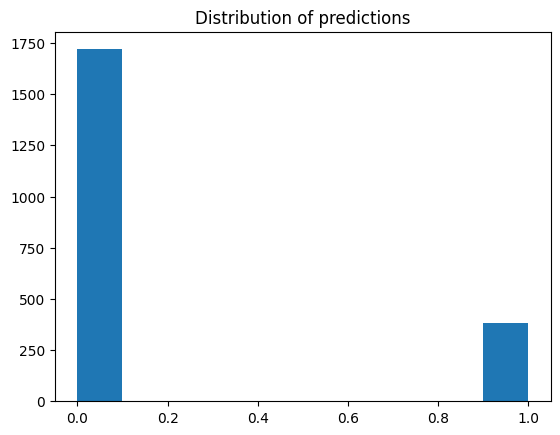

(array([0., 1.]), array([1719,  381], dtype=int64))
Accuracy: 0.6566666960716248
Loss: 0.7921174168586731
windowSize: 5000, stride: 0.25, batchSize: 50
8729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonl

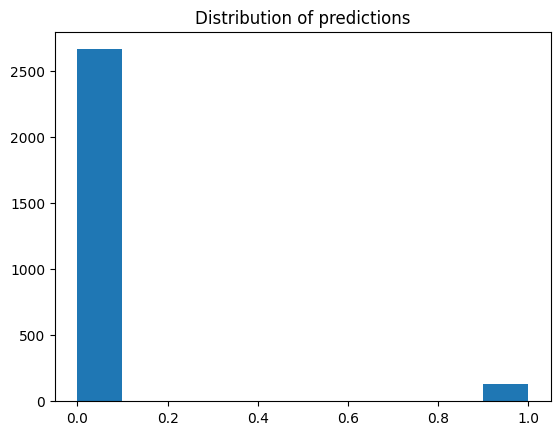

(array([0., 1.]), array([2667,  133], dtype=int64))
Accuracy: 0.6974999904632568
Loss: 1.3145893812179565
windowSize: 5000, stride: 0.16666666666666666, batchSize: 50
13074
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no a

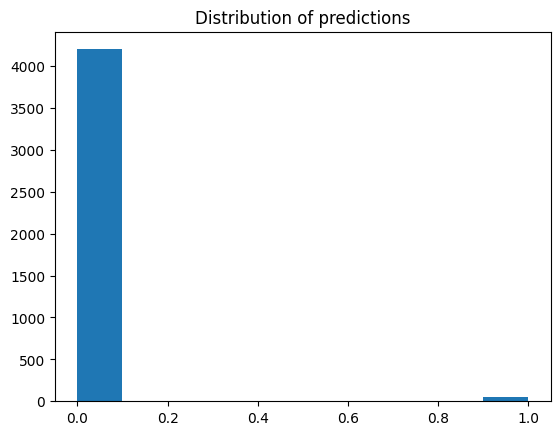

(array([0., 1.]), array([4199,   51], dtype=int64))
Accuracy: 0.681176483631134
Loss: 1.3838263750076294
windowSize: 5000, stride: 0.125, batchSize: 50
17409
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'poson

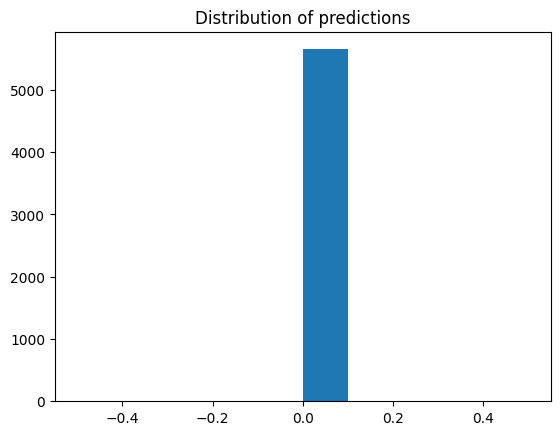

(array([0.]), array([5650], dtype=int64))
Accuracy: 0.7077876329421997
Loss: 0.6150071024894714
windowSize: 5000, stride: 1, batchSize: 50, loss: 0.7208598852157593, accuracy: 0.6528571248054504
windowSize: 5000, stride: 0.75, batchSize: 50, loss: 0.7310370802879333, accuracy: 0.6410526037216187
windowSize: 5000, stride: 0.5, batchSize: 50, loss: 0.9154693484306335, accuracy: 0.6592857241630554
windowSize: 5000, stride: 0.3333333333333333, batchSize: 50, loss: 0.7921174168586731, accuracy: 0.6566666960716248
windowSize: 5000, stride: 0.25, batchSize: 50, loss: 1.3145893812179565, accuracy: 0.6974999904632568
windowSize: 5000, stride: 0.16666666666666666, batchSize: 50, loss: 1.3838263750076294, accuracy: 0.681176483631134
windowSize: 5000, stride: 0.125, batchSize: 50, loss: 0.6150071024894714, accuracy: 0.7077876329421997


In [4]:
windowSize = 5000
batchSize = 50
stride = [1, 3/4, 1/2, 1/3, 1/4, 1/6, 1/8]
allResultsStride = []

for s in stride:
    print(f'windowSize: {windowSize}, stride: {s}, batchSize: {batchSize}')
    loss, accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], windowSize, int(s*windowSize), batch_size=50, verbose=False)
    
    # save results in variable
    results = {
        'windowSize': windowSize,
        'stride': s,
        'batchSize': batchSize,
        'loss': loss,
        'accuracy': accuracy,
        'model': model
    }
    allResultsStride.append(results)


# pretty print results
for result in allResultsStride:
    print(f'windowSize: {result["windowSize"]}, stride: {result["stride"]}, batchSize: {result["batchSize"]}, loss: {result["loss"]}, accuracy: {result["accuracy"]}')